In [ ]:
#!pip install torch
#!pip install mdtraj as md

import seaborn as sns
sns.set_style("ticks")
sns.set_palette("pastel")
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/trajectories/aspirin")

Mounted at /content/drive/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist

In [ ]:
def parse_xyz_multi_frame(filepath):
    with open(filepath, 'r') as file:
        frames = []
        while True:
            line = file.readline()
            if not line:
                break
            num_atoms = int(line.strip())
            file.readline()
            atoms = []
            coordinates = np.zeros((num_atoms, 3))
            for i in range(num_atoms):
                line = file.readline().strip().split()
                atoms.append(line[0])
                coordinates[i] = [float(x) for x in line[1:4]]
            frames.append((atoms, coordinates))
    return frames

frames_train = parse_xyz_multi_frame('aspirin_ccsd-train.xyz')
frames_test = parse_xyz_multi_frame('aspirin_ccsd-test.xyz')

combined_frames = frames_train + frames_test
frames_train = combined_frames[:1350]
frames_test = combined_frames[1350:]

train_frames = [coords for _, coords in frames_train]
test_frames = [coords for _, coords in frames_test]
train_frames_tensor = torch.tensor([coords.flatten() for coords in train_frames], dtype=torch.float32)
test_frames_tensor = torch.tensor([coords.flatten() for coords in test_frames], dtype=torch.float32)

bond_connectivities_dict = {
    0: [2, 5, 14],
    1: [3, 6, 15],
    2: [0, 3, 16],
    3: [1, 2, 17],
    4: [11, 18, 19, 20],
    5: [0, 6, 10],
    6: [1, 5, 12],
    7: [10],
    8: [11],
    9: [10, 13],
    10: [5, 7, 9],
    11: [4, 8, 12],
    12: [6, 11],
    13: [9],
    14: [0],
    15: [1],
    16: [2],
    17: [3],
    18: [4],
    19: [4],
    20: [4]
}

bond_connectivities = []
for atom, bonded_atoms in bond_connectivities_dict.items():
    for bonded_atom in bonded_atoms:
        bond_connectivities.append((atom, bonded_atom))

Epoch 0, Loss: 5.92524528503418
Epoch 10, Loss: 5.924982070922852
Epoch 20, Loss: 5.92496395111084
Epoch 30, Loss: 5.924957752227783
Epoch 40, Loss: 5.924954891204834
Epoch 50, Loss: 5.924952983856201
Epoch 60, Loss: 5.924952030181885
Epoch 70, Loss: 5.924952030181885
Epoch 80, Loss: 5.92495059967041
Epoch 90, Loss: 5.92495059967041
Epoch 100, Loss: 5.92495059967041
Epoch 110, Loss: 5.92495059967041
Epoch 120, Loss: 5.924950122833252
Epoch 130, Loss: 5.924950122833252
Epoch 140, Loss: 5.924950122833252
Epoch 150, Loss: 5.924950122833252
Epoch 160, Loss: 5.924950122833252
Epoch 170, Loss: 5.924950122833252
Epoch 180, Loss: 5.924950122833252
Epoch 190, Loss: 5.924950122833252
Epoch 200, Loss: 5.924950122833252
Epoch 210, Loss: 5.924950122833252
Epoch 220, Loss: 5.924950122833252
Epoch 230, Loss: 5.924950122833252
Epoch 240, Loss: 5.924949645996094
Epoch 250, Loss: 5.924949645996094
Epoch 260, Loss: 5.924949645996094
Epoch 270, Loss: 5.924949645996094
Epoch 280, Loss: 5.924949645996094
Ep

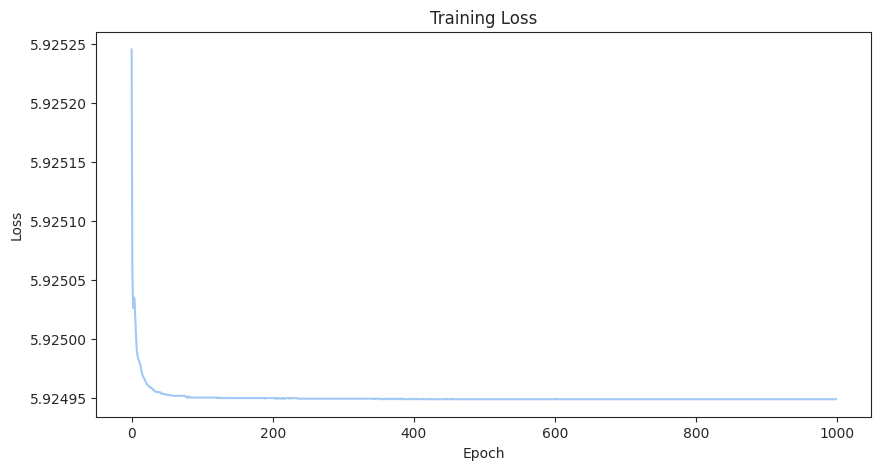

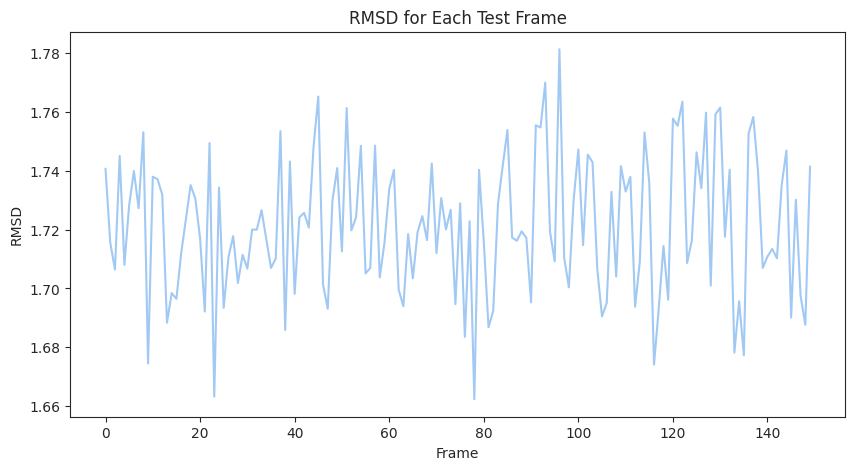

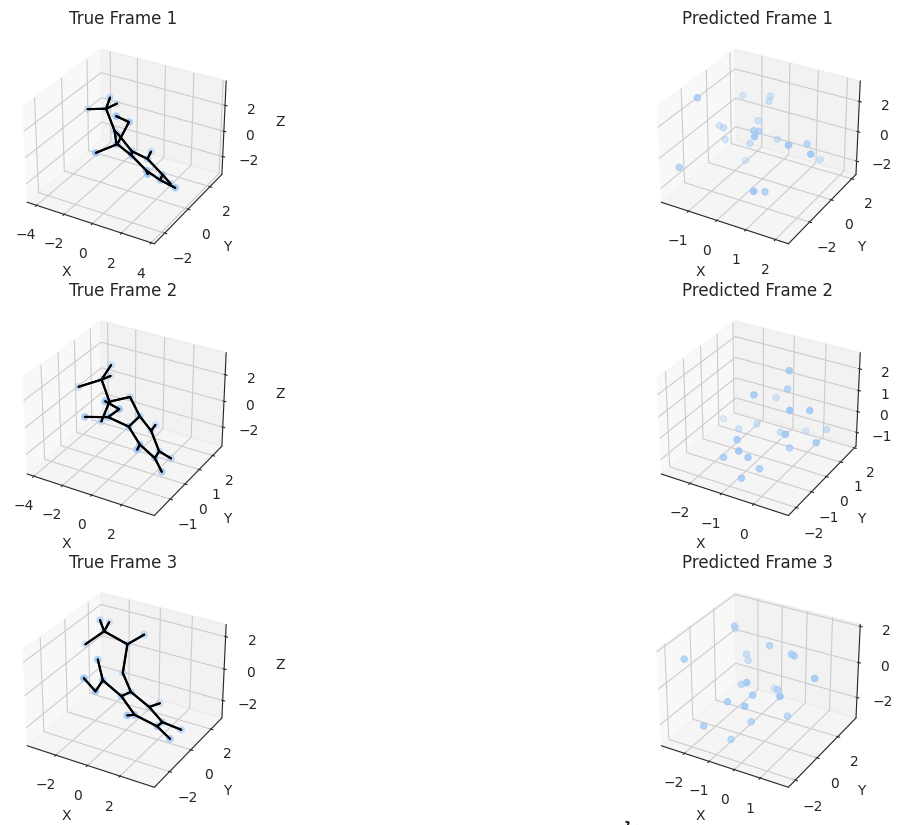

In [ ]:
class HNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(HNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, q):
        x = q  # Only use q for now
        # print(f'Input shape: {x.shape}')
        x = torch.relu(self.fc1(x))
        # print(f'After fc1 shape: {x.shape}')
        x = torch.relu(self.fc2(x))
        # print(f'After fc2 shape: {x.shape}')
        H = self.fc3(x)
        # print(f'Output H shape: {H.shape}')
        return H

def hnn_loss(q, H):
    dqdt_pred = torch.autograd.grad(H, q, grad_outputs=torch.ones_like(H), create_graph=True)[0]
    dpdt_pred = -dqdt_pred  # Placeholder for dpdt_pred, customize as needed
    # print(f'dqdt_pred shape: {dqdt_pred.shape}')
    # print(f'dpdt_pred shape: {dpdt_pred.shape}')
    return torch.mean((dqdt_pred - q) ** 2 + (dpdt_pred - q) ** 2)  # Customize this loss

def calculate_rmsd(true_coords, pred_coords):
    rmsd = np.sqrt(((true_coords - pred_coords) ** 2).mean(axis=None))
    return rmsd

# Training loop
input_dim = train_frames_tensor.shape[1]
hidden_dim = 256

# print(f'Input dimension: {input_dim}')
# print(f'Train frames tensor shape: {train_frames_tensor.shape}')

model = HNN(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    q = train_frames_tensor.clone().detach().requires_grad_(True)

    H_pred = model(q)
    # print(f'H_pred shape: {H_pred.shape}')

    loss = hnn_loss(q, H_pred)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Predict motion on test set
q_test = test_frames_tensor.clone().detach().requires_grad_(True)

# print(f'q_test shape: {q_test.shape}')

H_test_pred = model(q_test)
# print(f'H_test_pred shape: {H_test_pred.shape}')

dqdt_test_pred = torch.autograd.grad(H_test_pred, q_test, grad_outputs=torch.ones_like(H_test_pred), create_graph=True)[0]
dpdt_test_pred = -dqdt_test_pred

# print(f'dqdt_test_pred shape: {dqdt_test_pred.shape}')
# print(f'dpdt_test_pred shape: {dpdt_test_pred.shape}')

predicted_frames = dqdt_test_pred.detach().numpy().reshape(-1, 21, 3)  # Assuming 21 atoms
true_frames = test_frames_tensor.detach().numpy().reshape(-1, 21, 3)

rmsd_values = [calculate_rmsd(true_frames[i], predicted_frames[i]) for i in range(len(true_frames))]
average_rmsd = np.mean(rmsd_values)
print(f'Average RMSD: {average_rmsd}')

# Plot loss during training
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Plot RMSD for each frame in the test set
plt.figure(figsize=(10, 5))
plt.plot(rmsd_values)
plt.xlabel('Frame')
plt.ylabel('RMSD')
plt.title('RMSD for Each Test Frame')
plt.show()

# Plot predicted vs actual molecule in 3D for the first 3 test frames
def plot_molecule(ax, coords, title, connections=None):
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2])
    if connections is not None:
        for conn in connections:
            ax.plot([coords[conn[0], 0], coords[conn[1], 0]],
                    [coords[conn[0], 1], coords[conn[1], 1]],
                    [coords[conn[0], 2], coords[conn[1], 2]], 'k-')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

fig = plt.figure(figsize=(15, 10))
for i in range(3):
    ax = fig.add_subplot(3, 2, 2*i+1, projection='3d')
    plot_molecule(ax, true_frames[i], f'True Frame {i+1}', connections=bond_connectivities)

    ax = fig.add_subplot(3, 2, 2*i+2, projection='3d')
    plot_molecule(ax, predicted_frames[i], f'Predicted Frame {i+1}')
plt.show()

In [ ]:
|